In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

# 필요한 패키지와 라이브러리 가져온다.
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# 폰트 지정하기
plt.rcParams['font.family'] = 'gulim'

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_29940\3242504639.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
weather = pd.read_csv('../data/기상대기정보.csv', encoding='UTF-8')
weather.head(2)

,지점명,일시,지점,기온(°C),강수여부,풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),해면기압(hPa),...,Ozon,NO2,CO,SO2,증기압(hPa),이슬점온도(°C),시정(10m),지면온도(°C),월,전날기온
0,철원,2018-08-02 01:00:00,95,28.2,0,1.0,50.0,79.0,987.3,1004.6,...,0.023,0.003,0.3,0.001,30.2,24.2,1522.0,27.7,8,25.0
1,철원,2018-08-02 02:00:00,95,27.3,0,0.7,90.0,85.0,987.5,1004.9,...,0.024,0.003,0.3,0.001,30.7,24.5,1346.0,26.8,8,24.2


# 전국 기온 시계열 분석

In [3]:
w = weather[['일시','기온(°C)']]
w.head(2)

,일시,기온(°C)
0,2018-08-02 01:00:00,28.2
1,2018-08-02 02:00:00,27.3


In [4]:
w['일시'] = pd.to_datetime(w['일시'])

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_29940\1074407359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w['일시'] = pd.to_datetime(w['일시'])


In [5]:
w['일시'] = w['일시'].dt.date

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_29940\3158281393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w['일시'] = w['일시'].dt.date


In [6]:
w = w.groupby('일시').mean()

In [7]:
w.index = pd.to_datetime(w.index)

In [8]:
w

,기온(°C)
일시,
2018-01-01,1.692606
2018-01-02,1.718685
2018-01-03,-0.052901
2018-01-04,-0.997865
2018-01-05,1.100000
...,...
2022-12-27,-1.663751
2022-12-28,-0.933783
2022-12-29,-2.029012


In [9]:
# 학습용, 검증용 데이터 분리
w_tr = w[w.index<'2022-07-01']
w_te = w[w.index>='2022-07-01']

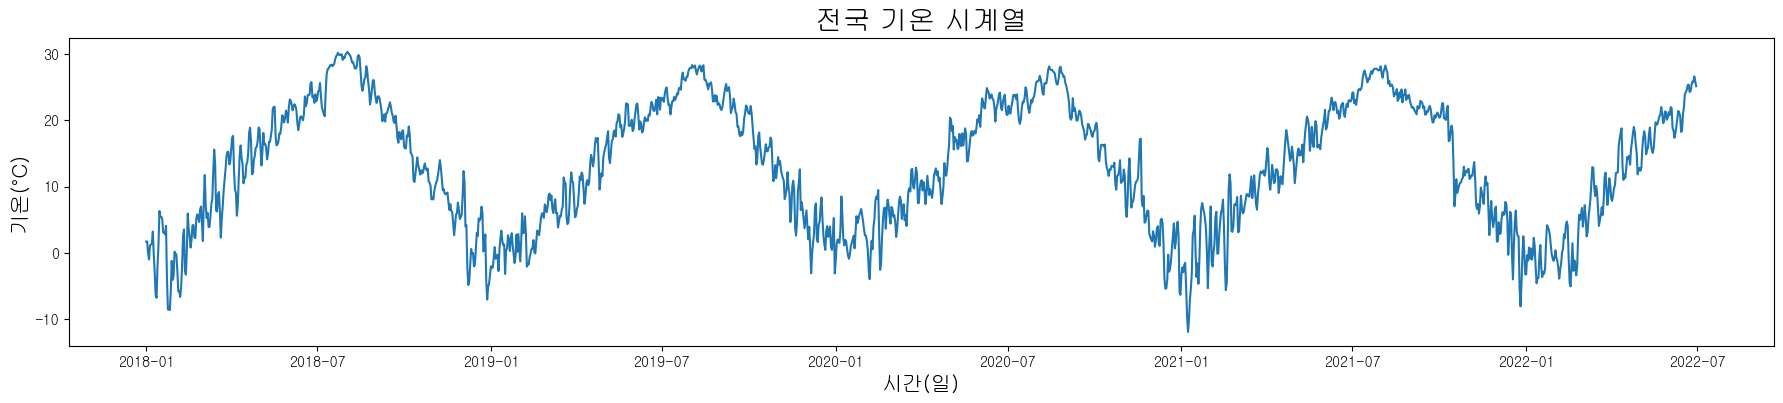

In [10]:
# 시계열 그래프
plt.figure(figsize=(22,4))
plt.plot(w_tr.index, w_tr['기온(°C)'].values)
plt.title('전국 기온 시계열', fontsize=20)
plt.xlabel('시간(일)', fontsize=15)
plt.ylabel('기온(°C)', fontsize=15)
plt.savefig("전국기온시계열.png", transparent=True)

### 시계열 그래프 해석
- 우리가 평소 아는 것과 같이 일년을 주기로 계절성을 보임

## 시계열 분해

<Figure size 640x480 with 0 Axes>

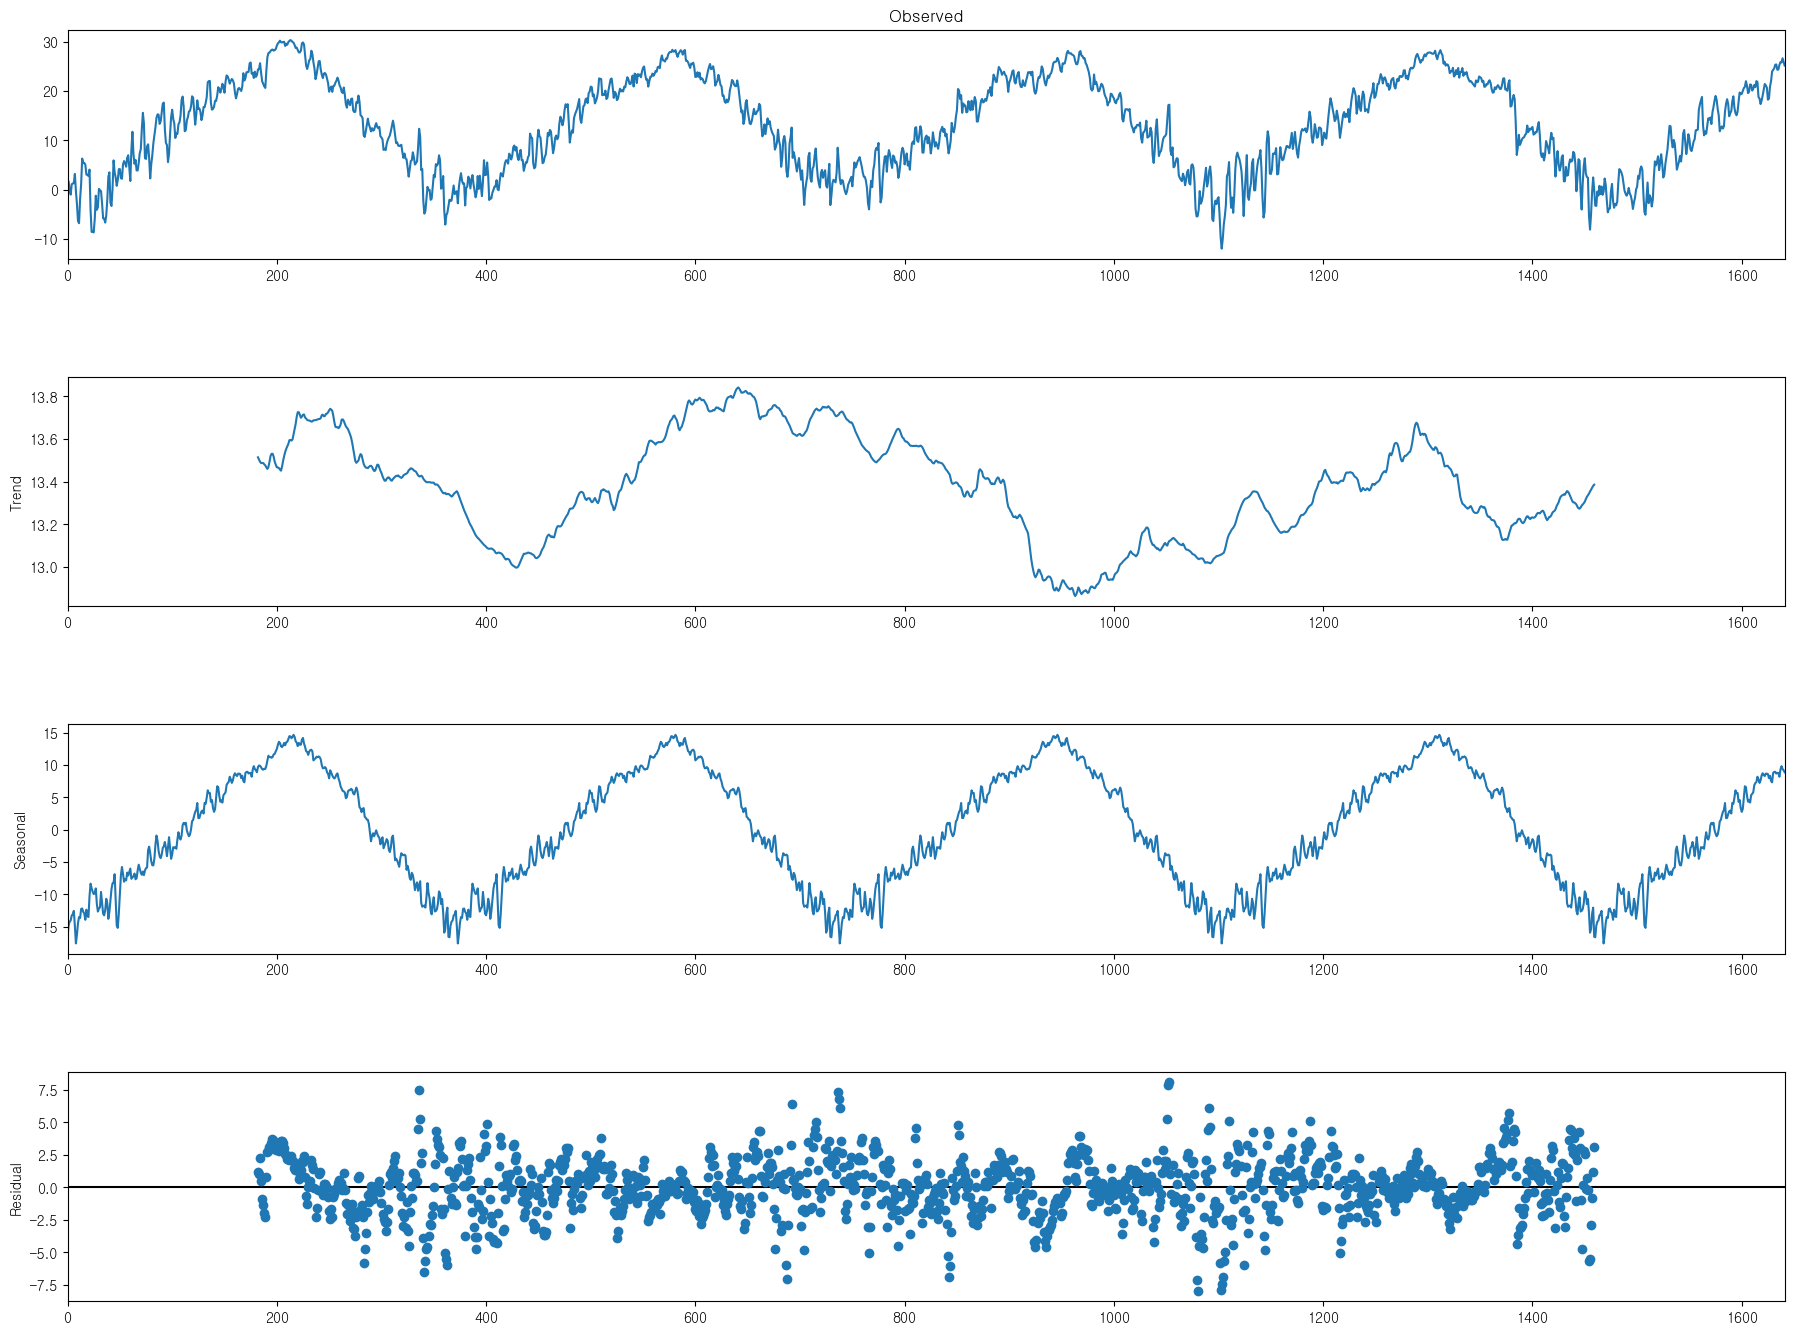

In [11]:
result = seasonal_decompose(w_tr['기온(°C)'].values, model='additive', period=365)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)
plt.savefig("시계열분해.png", transparent=True)

## 시계열 분해 그래프 해석
- 계절성에서 패턴이 보이고, 불규칙 요소에서도 패턴이 보임
- 정상성을 만족하지 못 할 것을 예상할 수 있음

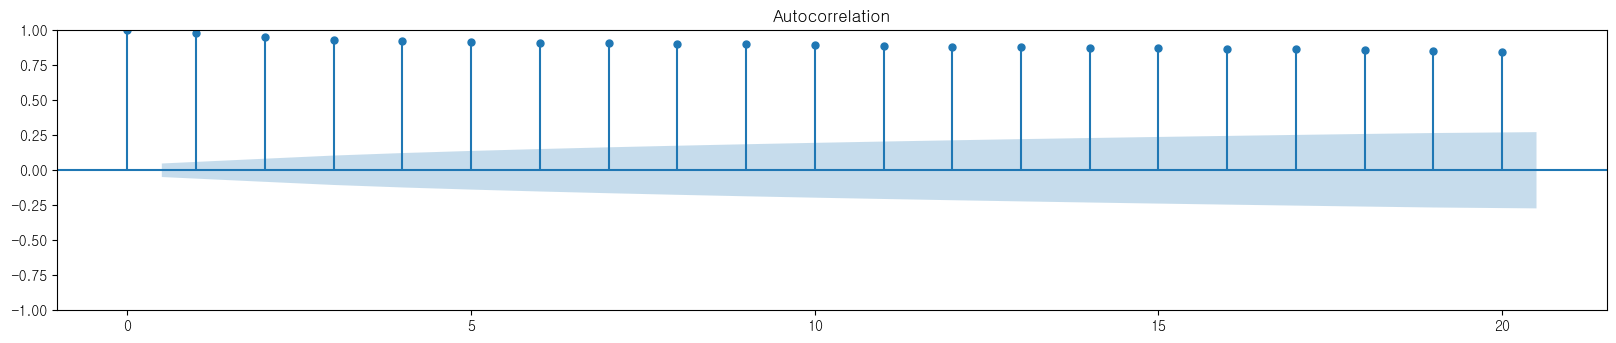

In [12]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(w_tr['기온(°C)'].values, lags=20, ax=ax1)
plt.savefig("ACF.png", transparent=True)

In [13]:
adfuller(w_tr['기온(°C)'].values) # p-value: 0.078

(-2.6774874348742226,
 0.07801559762007827,
 25,
 1616,
 {'1%': -3.434403043188966,
  '5%': -2.863330182785859,
  '10%': -2.567723055843177},
 6308.588337929488)

### ACF 값 그래프 해석
- ACF 값이 아주 천천히 감소: 정상성 만족 못할 것을 예상
- ADF 검정 결과: H0 기각 못함 = 정상성 만족 못함

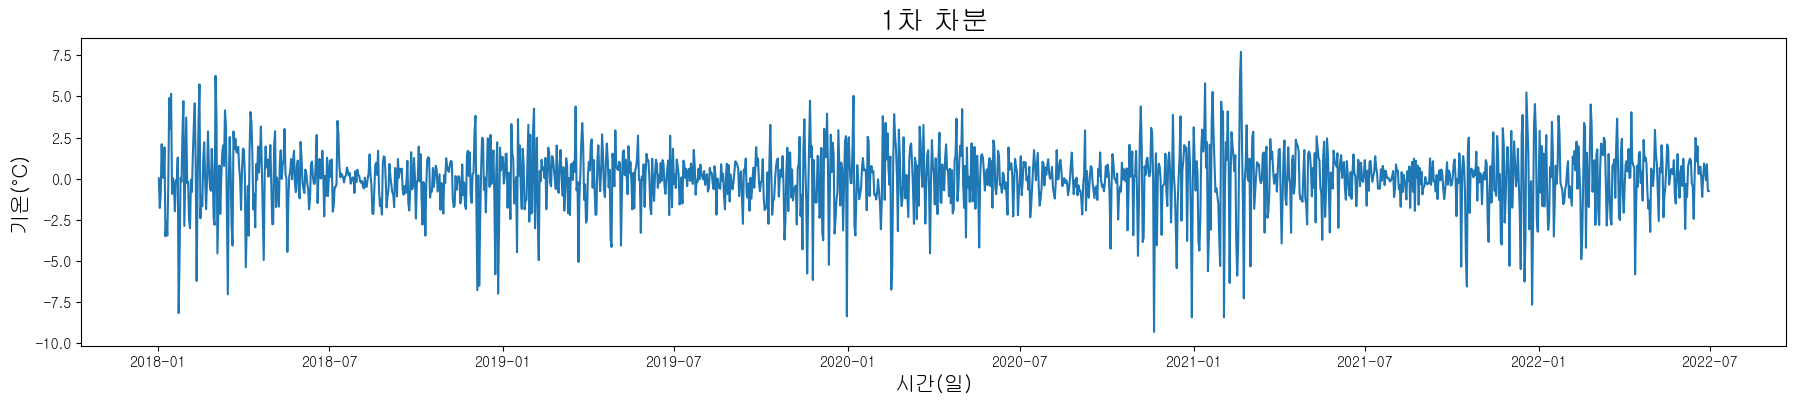

In [14]:
# 1차 차분
w_tr_diff = w_tr['기온(°C)'] - w_tr['기온(°C)'].shift()
plt.figure(figsize=(22,4))
plt.plot(w_tr_diff)
plt.title('1차 차분', fontsize=20)
plt.xlabel('시간(일)', fontsize=15)
plt.ylabel('기온(°C)', fontsize=15)
plt.savefig("1차차분.png", transparent=True)

In [15]:
adfuller(w_tr_diff.values[1:]) # p-value: 1.99e-10

(-7.231092147567744,
 1.9937786457635977e-10,
 24,
 1616,
 {'1%': -3.434403043188966,
  '5%': -2.863330182785859,
  '10%': -2.567723055843177},
 6310.690184091069)

### 1차 차분 그래프 해석
- 일정한 패턴이 사라짐
- 정상성 만족할 것을 예상
- ADF 검정 결과: H0 기각 = 정상성 만족
- d = 1

c:\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


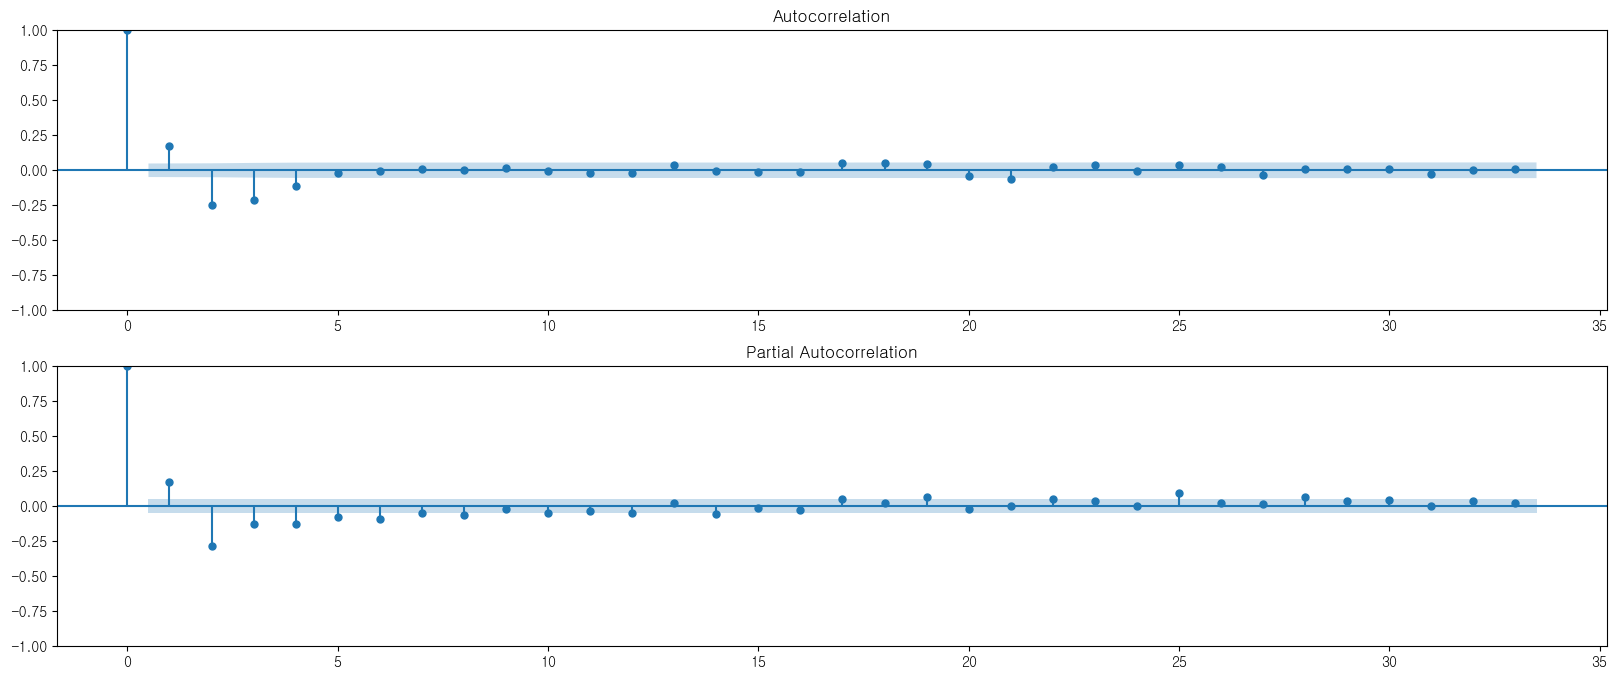

In [16]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(w_tr_diff.values[1:], ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(w_tr_diff.values[1:], ax=ax2)
plt.savefig("ACF와PACF.png", transparent=True)

### 차분 데이터로 그린 ACF와 PACF 그래프 해석
- ACF 그래프는 3번째 lag 이후에 0에 수렴
- PACF 그래프는 4번째 lag 이후에 0에 수렴
- p = 4, q = 5

In [17]:
# ARIMA(5,1,4) 모형
model = ARIMA(w_tr['기온(°C)'], order = (4,1,5)).fit()
model.summary()

c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 기온(°C)   No. Observations:                 1642
Model:                 ARIMA(4, 1, 5)   Log Likelihood               -3199.642
Date:                Thu, 06 Jul 2023   AIC                           6419.283
Time:                        10:16:50   BIC                           6473.314
Sample:                    01-01-2018   HQIC                          6439.321
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2912      0.066     -4.399      0.000      -0.421      -0.161
ar.L2          1.4456      0.055     26.180      0.000       1.337       1.554
ar.L3          0.3298      0.062      5.340      0.000       0.209       0.451
ar.L4         -0.5131      0.049    -10.489      0.000      -0.609      -0.417
ma.L1          0.4039      0.066      6.147      0.000       0.275       0.533
ma.L2         -1.7580      0.047    -37.273      0.000      -1.850      -1.666
ma.L3         -0.8049      0.088     -9.111      0.000      -0.978      -0.632
ma.L4          0.8020      0.044     18.254      0.000       0.716       0.888
ma.L5          0.3892      0.029     13.548      0.000       0.333       0.446
sigma2         2.8891      0.072     40.124      0.000       2.748       3.030
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               503.22
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -0.62
Prob(H) (two-sided):                  0.39   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
predictions = model.predict(start=365-len(w_te)+1, end=365,dynamic=False)
predictions.index = pd.date_range(start='2022-07-01', end='2022-12-31')
predictions

2022-07-01    23.701025
2022-07-02    24.629320
2022-07-03    24.254841
2022-07-04    25.807694
2022-07-05    22.986242
                ...    
2022-12-27    -5.580611
2022-12-28    -5.448437
2022-12-29    -3.310956
2022-12-30    -4.221506
2022-12-31    -2.230451
Freq: D, Name: predicted_mean, Length: 184, dtype: float64

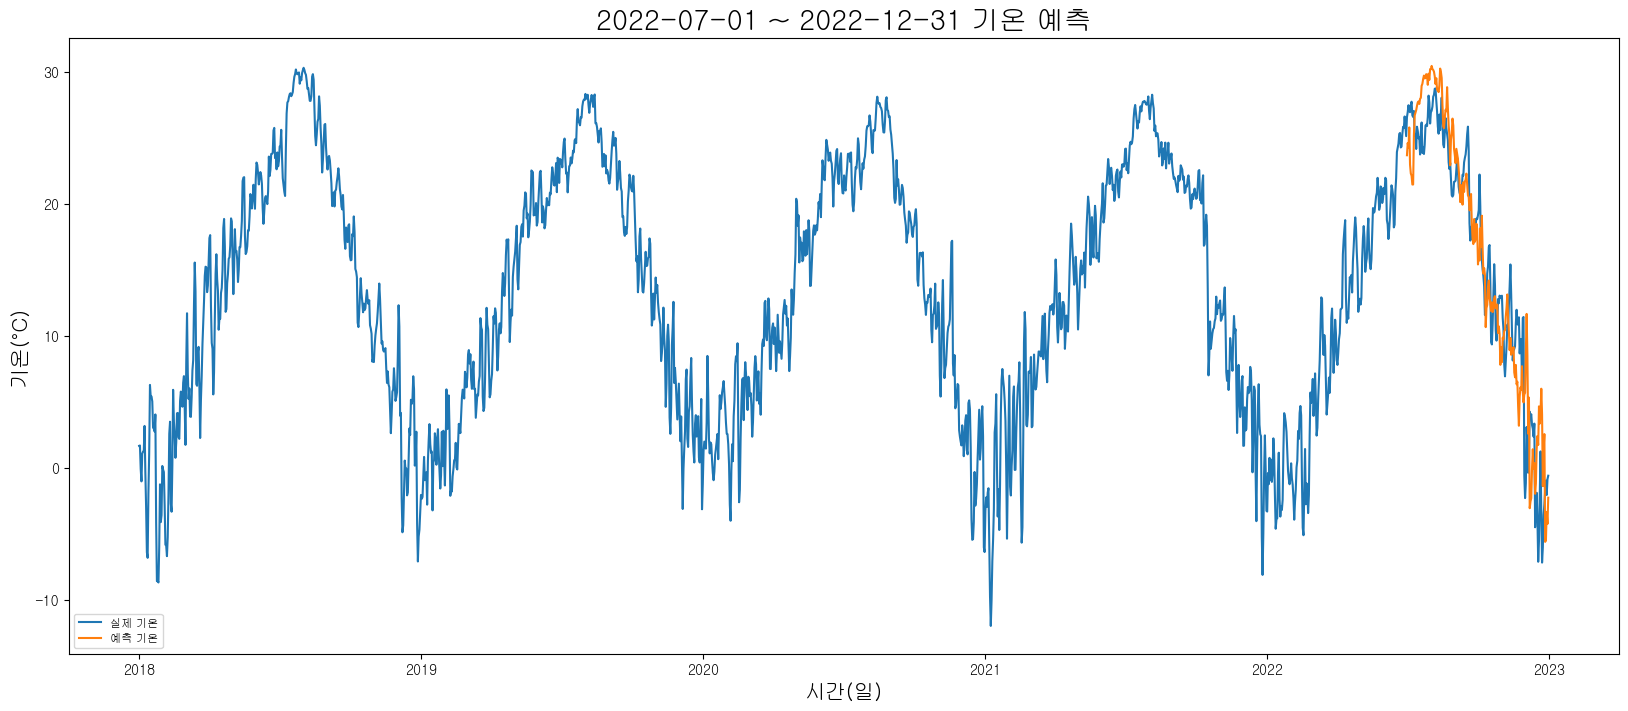

In [19]:
plt.figure(figsize=(20,8))
plt.plot(w['기온(°C)'],label='실제 기온')
plt.plot(predictions,label='예측 기온')
plt.legend(loc='lower left',fontsize=8)
plt.title('2022-07-01 ~ 2022-12-31 기온 예측', fontsize=20)
plt.xlabel('시간(일)', fontsize=15)
plt.ylabel('기온(°C)', fontsize=15)
plt.savefig("기온예측.png", transparent=True)

In [25]:
import numpy as np
mape = np.mean(np.abs((w_te['기온(°C)'].values - predictions) / w_te['기온(°C)'].values)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 62.04%
